# Polarized observations

This tutorial covers working with polarized instrument and maps, and recovering polarized maps from observations.

We start with a normal instrument, and create two orthogonally polarized copies of each detector by setting ``polarized: True`` in the ``Array`` config:

In [1]:
import maria
from maria.instrument import Band

f090 = Band(
    center=90e9,  # in Hz
    width=20e9,  # in Hz
    NET_RJ=40e-6,  # in K sqrt(s)
    knee=1e0,    # in Hz
    gain_error=5e-2)

f150 = Band(
    center=150e9, 
    width=30e9, 
    NET_RJ=60e-6, 
    knee=1e0, 
    gain_error=5e-2)

array = {"field_of_view": 0.5, 
         "shape": "circle", 
         "beam_spacing": 1.5,
         "primary_size": 10, 
         "polarized": True,
         "bands": [f090, f150]}

instrument = maria.get_instrument(array=array)

print(instrument.arrays)

          n     FOV baseline        bands polarized
array1  652  0.478°      0 m  [f090,f150]      True


We can see the resulting polarization footprint in the instrument plot:

Instrument(1 array)
├ arrays:
│            n     FOV baseline        bands polarized
│  array1  652  0.478°      0 m  [f090,f150]      True
│ 
└ bands:
      name   center   width    η         NEP      NET_RJ         NET_CMB     FWHM
   0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK_RJ√s  49.13 uK_CMB√s   1.458’
   1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK_RJ√s    104 uK_CMB√s  0.8748’


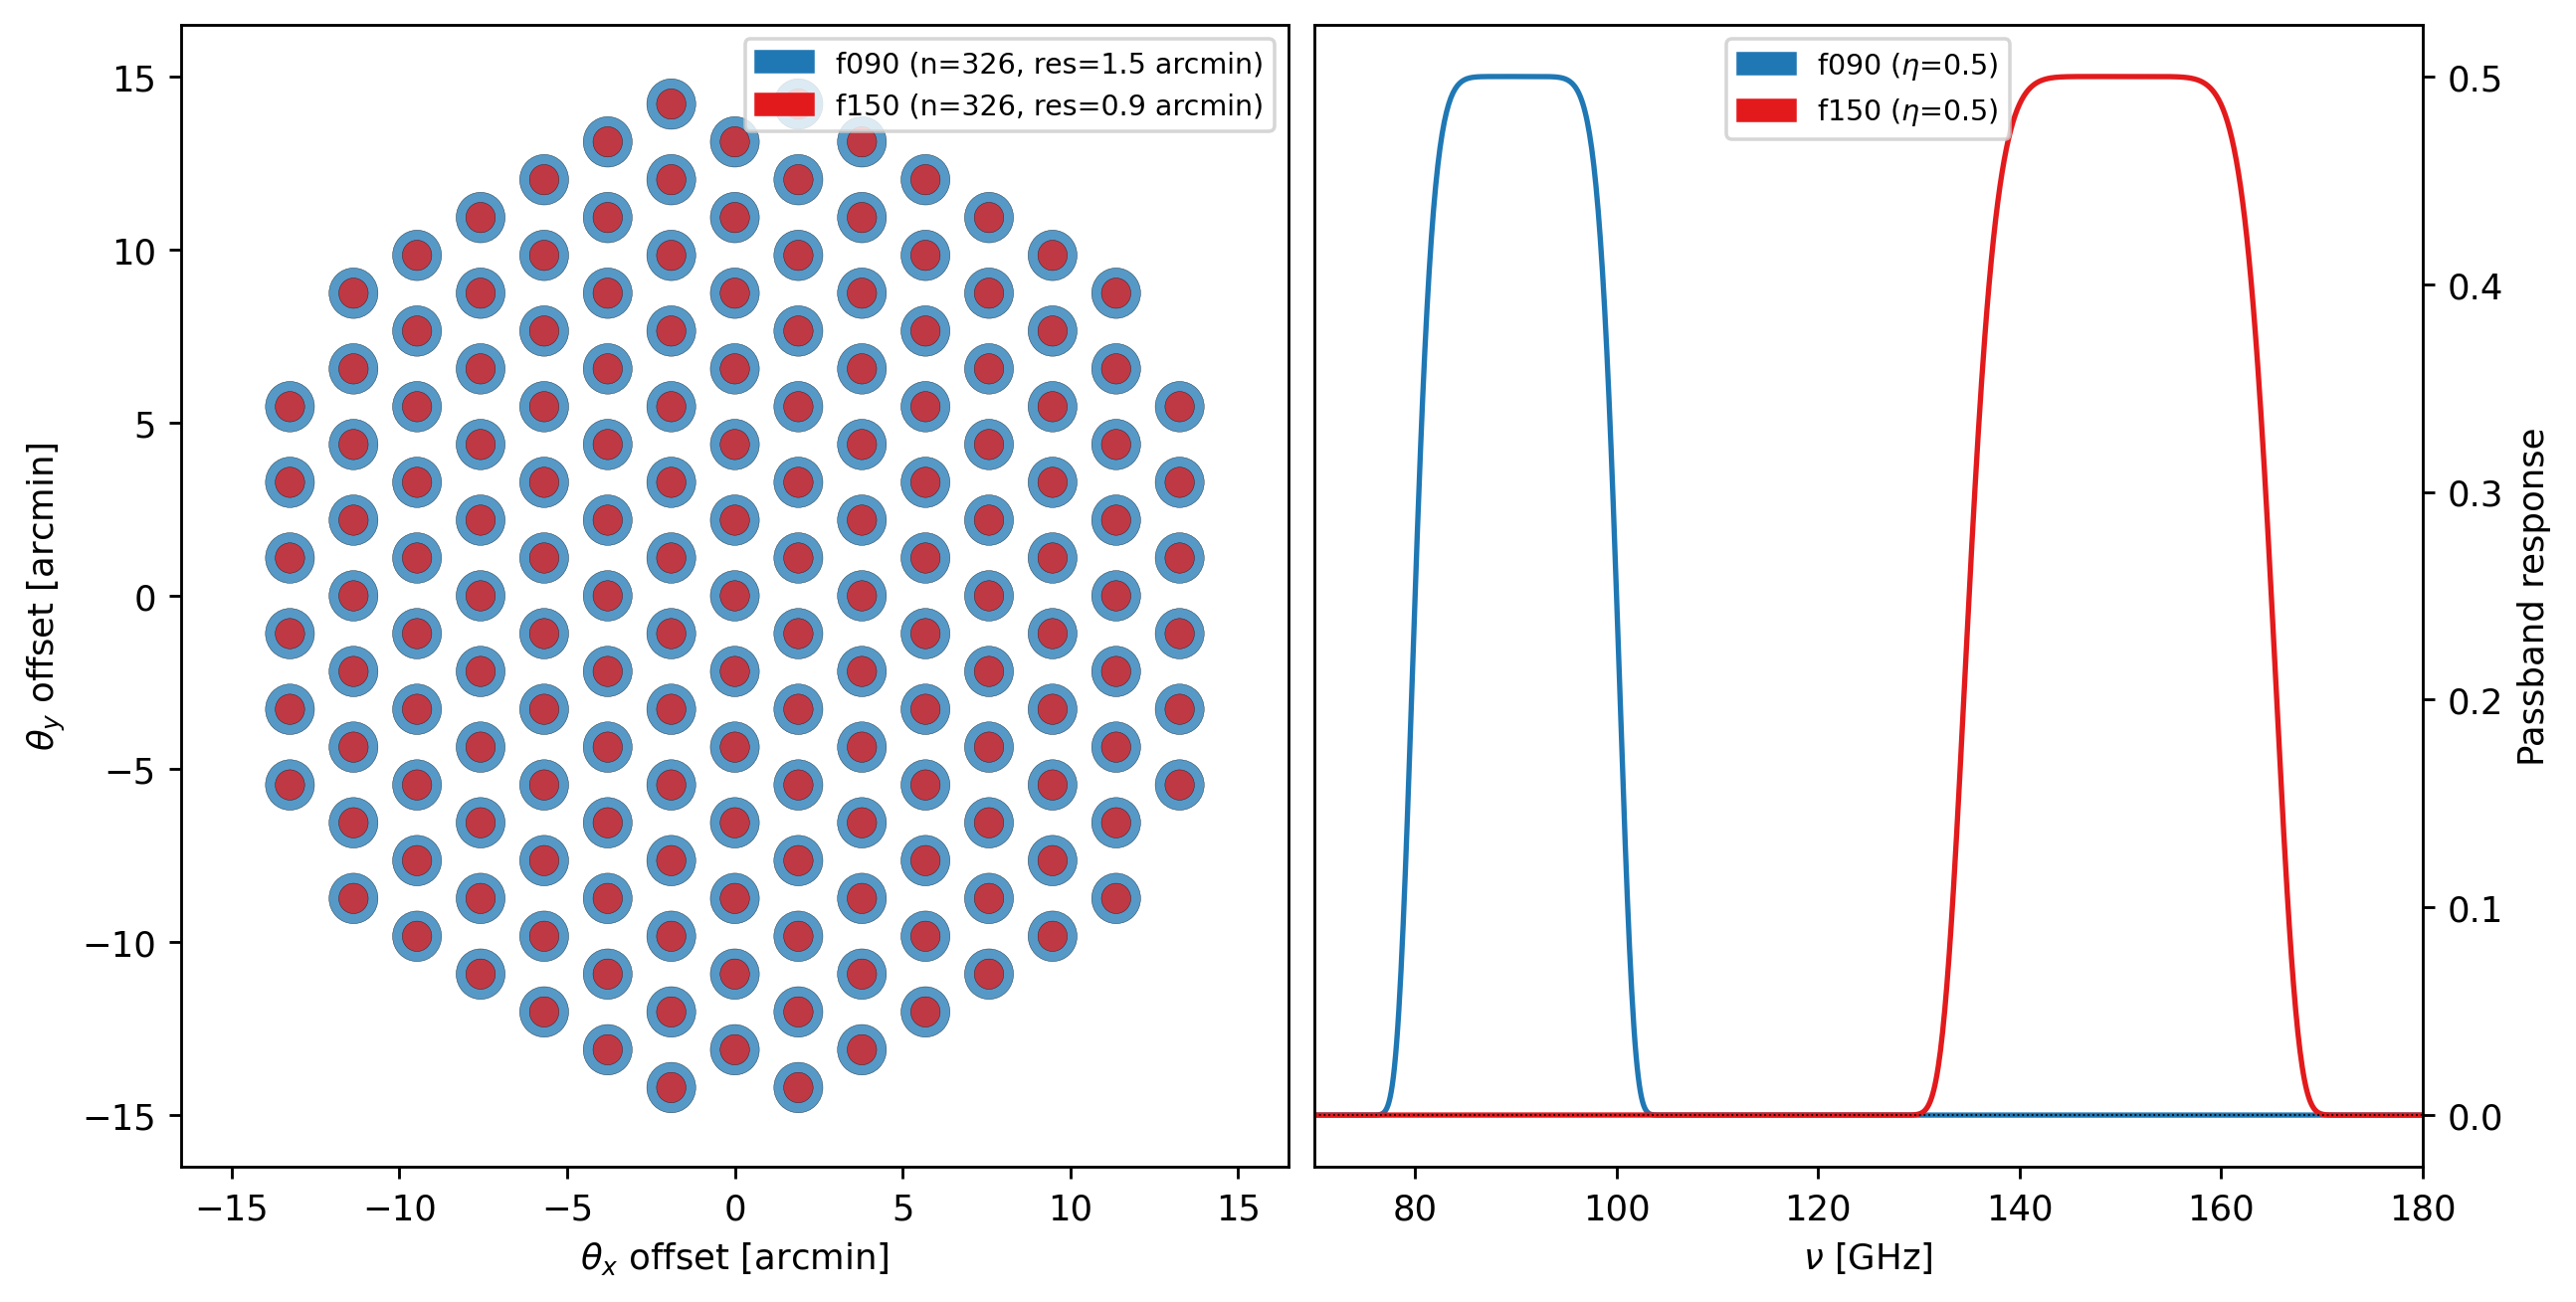

In [2]:
print(instrument)
instrument.plot()

Let's observe the use the Einstein map, which has a faint polarization signature underneath the unpolarized signal of Einstein's face. Remember that all maps are five dimensional (stokes, frequency, time, y, x); this map has four channels in the stokes dimensions (the I, Q, U, and V [Stokes parameters](https://en.wikipedia.org/wiki/Stokes_parameters)). We can plot all the channels by giving ``plot`` a shaped set of stokes parameters.

2025-11-23 19:43:18.556 INFO: Fetching https://github.com/thomaswmorris/maria-data/raw/master/maps/einstein.h5


Downloading:   0%|                | 0.00/931k [00:00<?, ?B/s]

Downloading: 100%|████████████████| 931k/931k [00:00<00:00, 41.4MB/s]

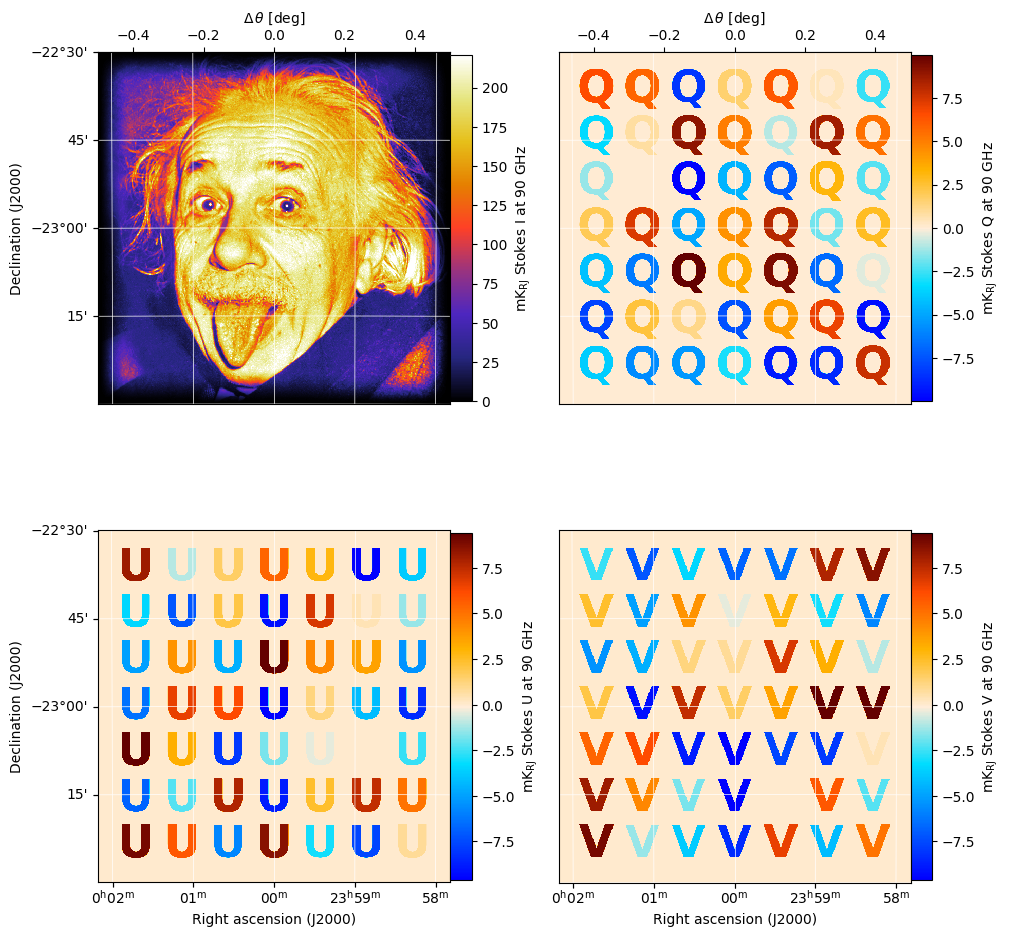

In [3]:
from maria.io import fetch

input_map = maria.map.load(fetch("maps/einstein.h5"))
input_map.plot(stokes=[["I", "Q"], 
                       ["U", "V"]])

PlanList(1 plans, 900 s):
                           start_time duration  target(ra,dec)    center(az,el)
chunk                                                                          
0      2025-11-23 22:09:37.195 +00:00    900 s  (11.47”, -23°)  (95.76°, 61.8°)


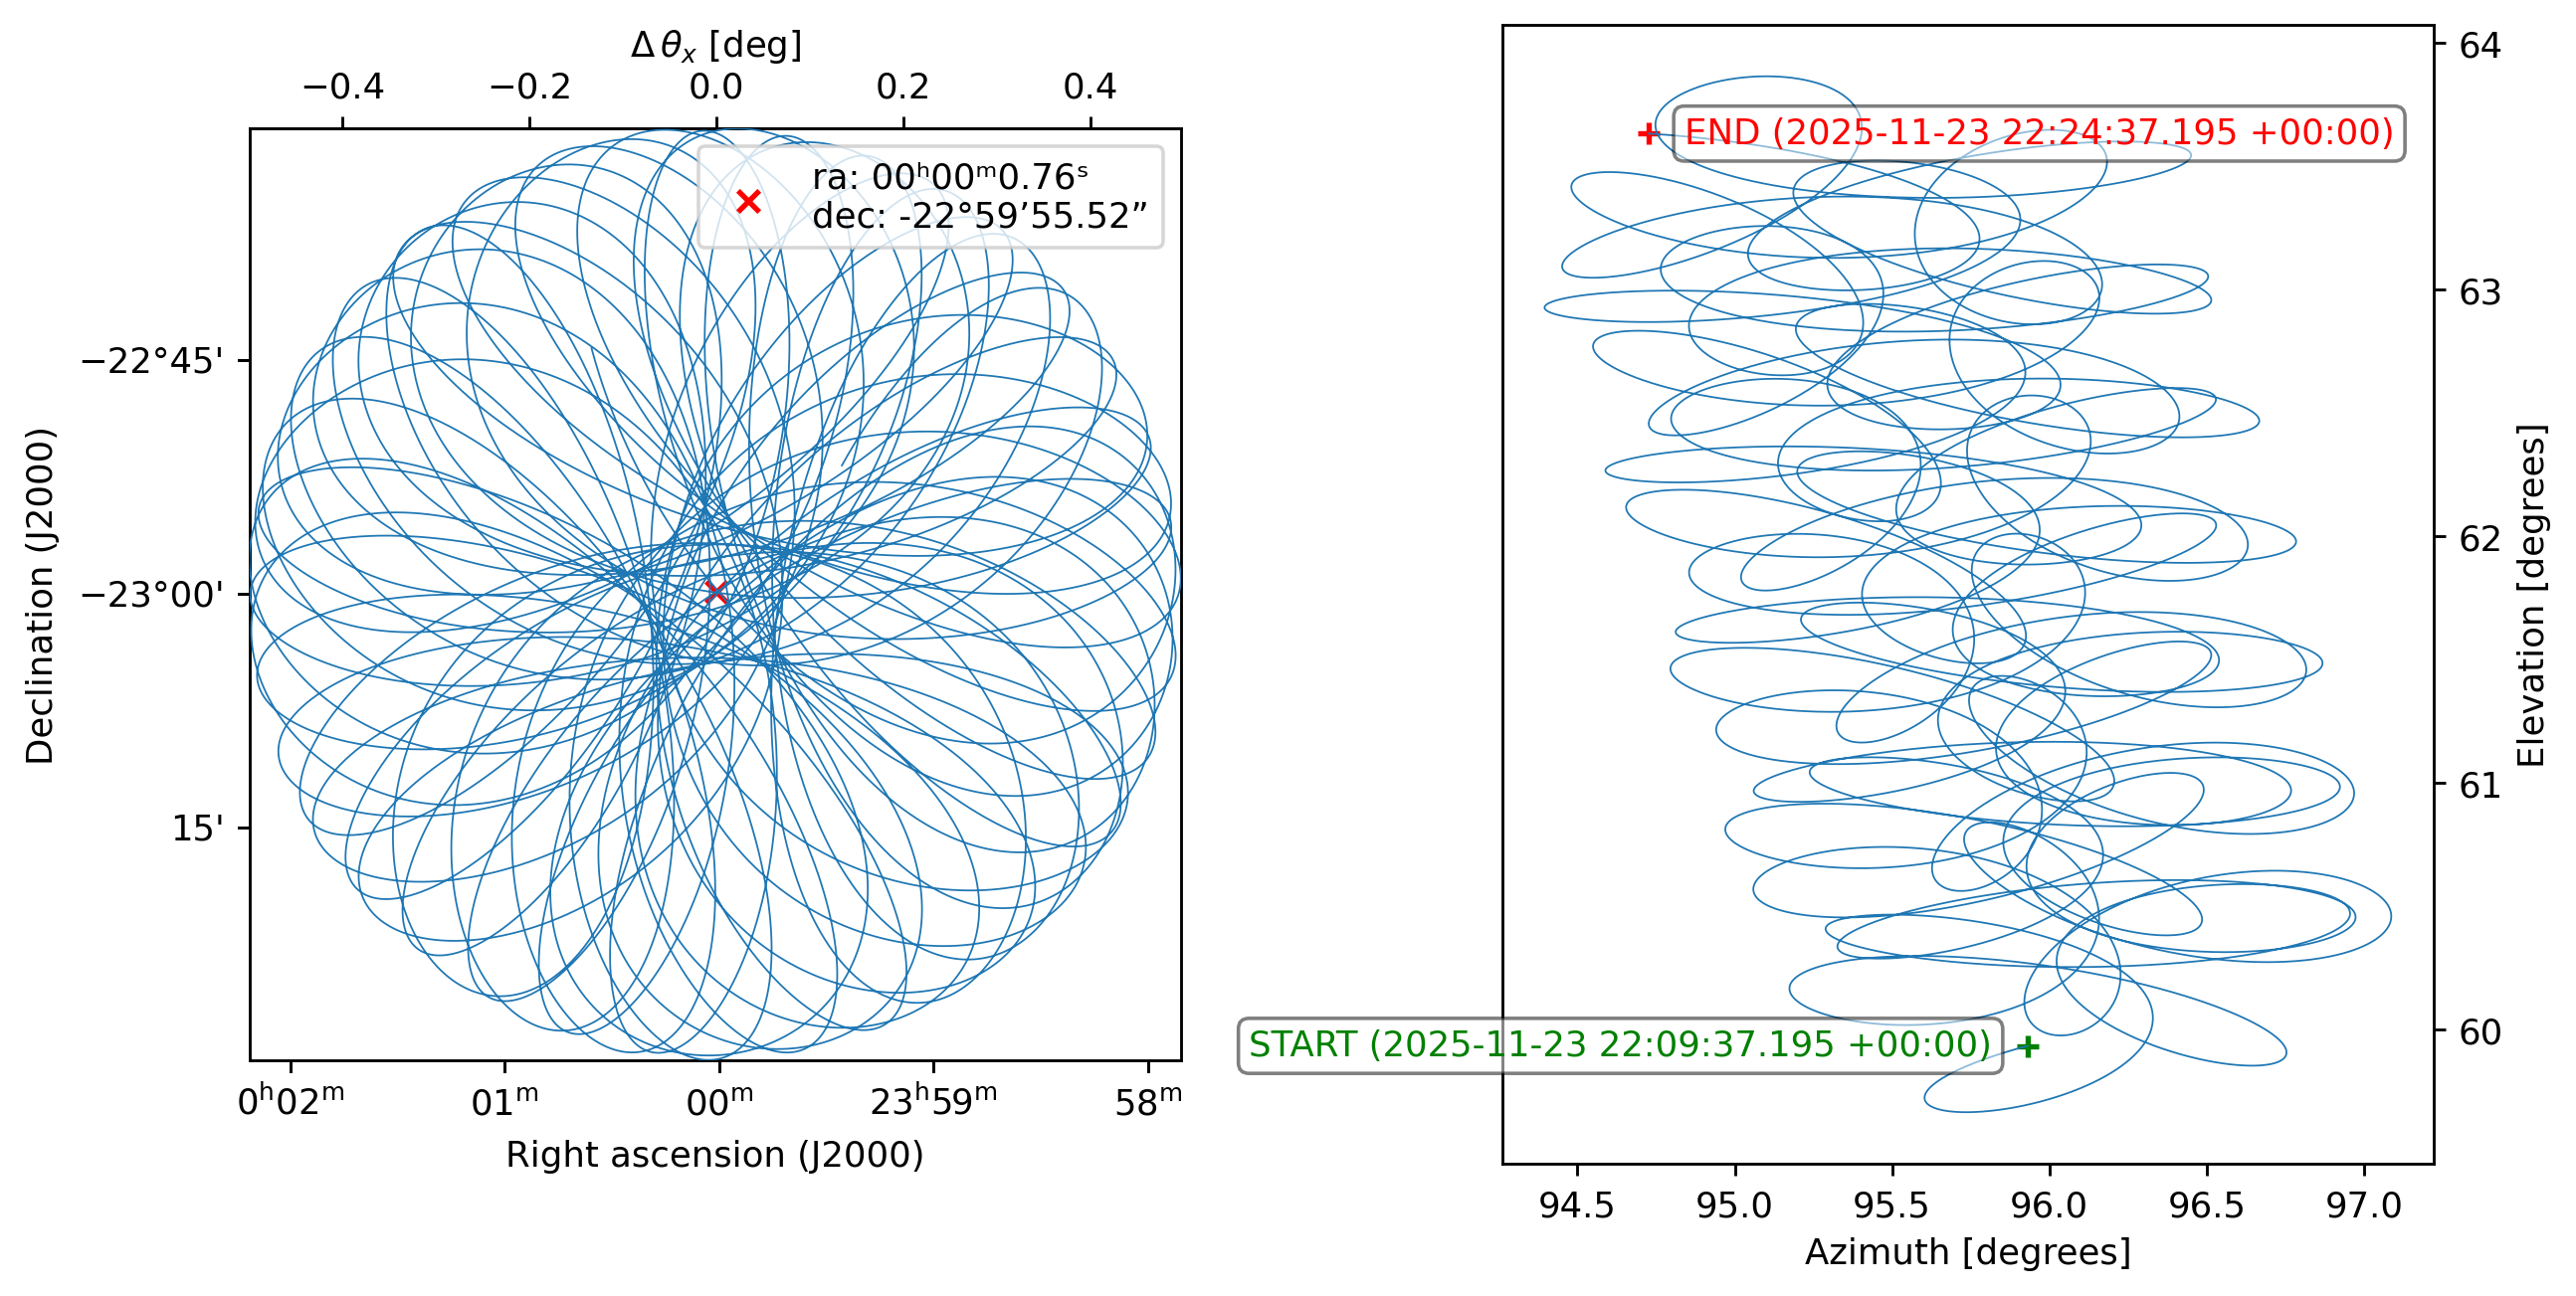

In [4]:
from maria import Planner

planner = Planner(target=input_map, site="llano_de_chajnantor", constraints={"el": (60, 90)})
plans = planner.generate_plans(total_duration=900,  # in seconds
                               sample_rate=50)  # in Hz

plans[0].plot()
print(plans)

In [5]:
sim = maria.Simulation(
    instrument,
    plans=plans,
    site="llano_de_chajnantor",
    atmosphere="2d",
    atmosphere_kwargs={"weather": {"pwv": 0.5}},
    map=input_map
)

print(sim)

Simulation
├ Instrument(1 array)
│ ├ arrays:
│ │            n     FOV baseline        bands polarized
│ │  array1  652  0.478°      0 m  [f090,f150]      True
│ │ 
│ └ bands:
│       name   center   width    η         NEP      NET_RJ         NET_CMB     FWHM
│    0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK_RJ√s  49.13 uK_CMB√s   1.458’
│    1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK_RJ√s    104 uK_CMB√s  0.8748’
├ Site:
│   region: chajnantor
│   timezone: America/Santiago
│   location:
│     longitude: 67°45’17.28” W
│     latitude:  23°01’45.84” S
│     altitude: 5064 m
│   seasonal: True
│   diurnal: True
├ PlanList(1 plans, 900 s):
│                            start_time duration  target(ra,dec)    center(az,el)
│ chunk                                                                          
│ 0      2025-11-23 22:09:37.195 +00:00    900 s  (11.47”, -23°)  (95.76°, 61.8°)
├ '2d'
└ ProjectionMap:
    shape(stokes, nu, t, y, x): (4, 1, 1, 685, 685)
    stokes: IQUV
    nu

2025-11-23 19:43:29.622 INFO: Simulating observation 1 of 1


Constructing atmosphere:   0%|                | 0/8 [00:00<?, ?it/s]

Constructing atmosphere:  12%|██              | 1/8 [00:05<00:40,  5.84s/it]

Constructing atmosphere:  25%|████            | 2/8 [00:11<00:34,  5.69s/it]

Constructing atmosphere:  38%|██████          | 3/8 [00:17<00:29,  5.99s/it]

Constructing atmosphere:  50%|████████        | 4/8 [00:24<00:25,  6.28s/it]

Constructing atmosphere:  62%|██████████      | 5/8 [00:31<00:19,  6.66s/it]

Constructing atmosphere:  75%|████████████    | 6/8 [00:37<00:12,  6.25s/it]

Constructing atmosphere:  88%|██████████████  | 7/8 [00:45<00:06,  6.96s/it]

Constructing atmosphere: 100%|████████████████| 8/8 [00:51<00:00,  6.59s/it]

Constructing atmosphere: 100%|████████████████| 8/8 [00:51<00:00,  6.44s/it]

Generating turbulence:   0%|                | 0/8 [00:00<?, ?it/s]

Generating turbulence:  25%|████            | 2/8 [00:00<00:00, 12.49it/s]

Generating turbulence:  50%|████████        | 4/8 [00:00<00:00, 10.29it/s]

Generating turbulence:  75%|████████████    | 6/8 [00:00<00:00,  6.73it/s]

Generating turbulence:  88%|██████████████  | 7/8 [00:01<00:00,  3.95it/s]

Generating turbulence: 100%|████████████████| 8/8 [00:02<00:00,  2.83it/s]

Generating turbulence: 100%|████████████████| 8/8 [00:02<00:00,  3.97it/s]

Sampling turbulence:   0%|                | 0/8 [00:00<?, ?it/s]

Sampling turbulence:  12%|██              | 1/8 [00:02<00:14,  2.08s/it]

Sampling turbulence:  25%|████            | 2/8 [00:03<00:09,  1.66s/it]

Sampling turbulence:  38%|██████          | 3/8 [00:04<00:07,  1.51s/it]

Sampling turbulence:  50%|████████        | 4/8 [00:06<00:05,  1.47s/it]

Sampling turbulence:  62%|██████████      | 5/8 [00:07<00:04,  1.45s/it]

Sampling turbulence:  75%|████████████    | 6/8 [00:09<00:02,  1.47s/it]

Sampling turbulence:  88%|██████████████  | 7/8 [00:10<00:01,  1.47s/it]

Sampling turbulence: 100%|████████████████| 8/8 [00:12<00:00,  1.48s/it]

Sampling turbulence: 100%|████████████████| 8/8 [00:12<00:00,  1.51s/it]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:02<00:02,  2.31s/it, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:02<00:02,  2.31s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:03<00:00,  1.43s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:03<00:00,  1.57s/it, band=f150]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=, channel=, stokes=]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]               

Sampling map:  50%|████████        | 1/2 [00:08<00:08,  8.24s/it, band=f090]

Sampling map:  50%|████████        | 1/2 [00:08<00:08,  8.24s/it, band=f150]

Sampling map: 100%|████████████████| 2/2 [00:15<00:00,  7.64s/it, band=f150]

Sampling map: 100%|████████████████| 2/2 [00:15<00:00,  7.73s/it, band=f150]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  1.21it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  1.21it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:01<00:00,  1.58it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:01<00:00,  1.51it/s, band=f150]

2025-11-23 19:45:16.591 INFO: Simulated observation 1 of 1 in 107 s


[TOD(shape=(652, 45000), fields=['atmosphere', 'map', 'noise'], units='K_RJ', start=2025-11-23 22:24:37.175 +00:00, duration=900.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-11-23T19:44:58.449144+00:00]>, 'altitude': 5064.0, 'region': 'chajnantor', 'pwv': 0.5, 'base_temperature': 278.236})]


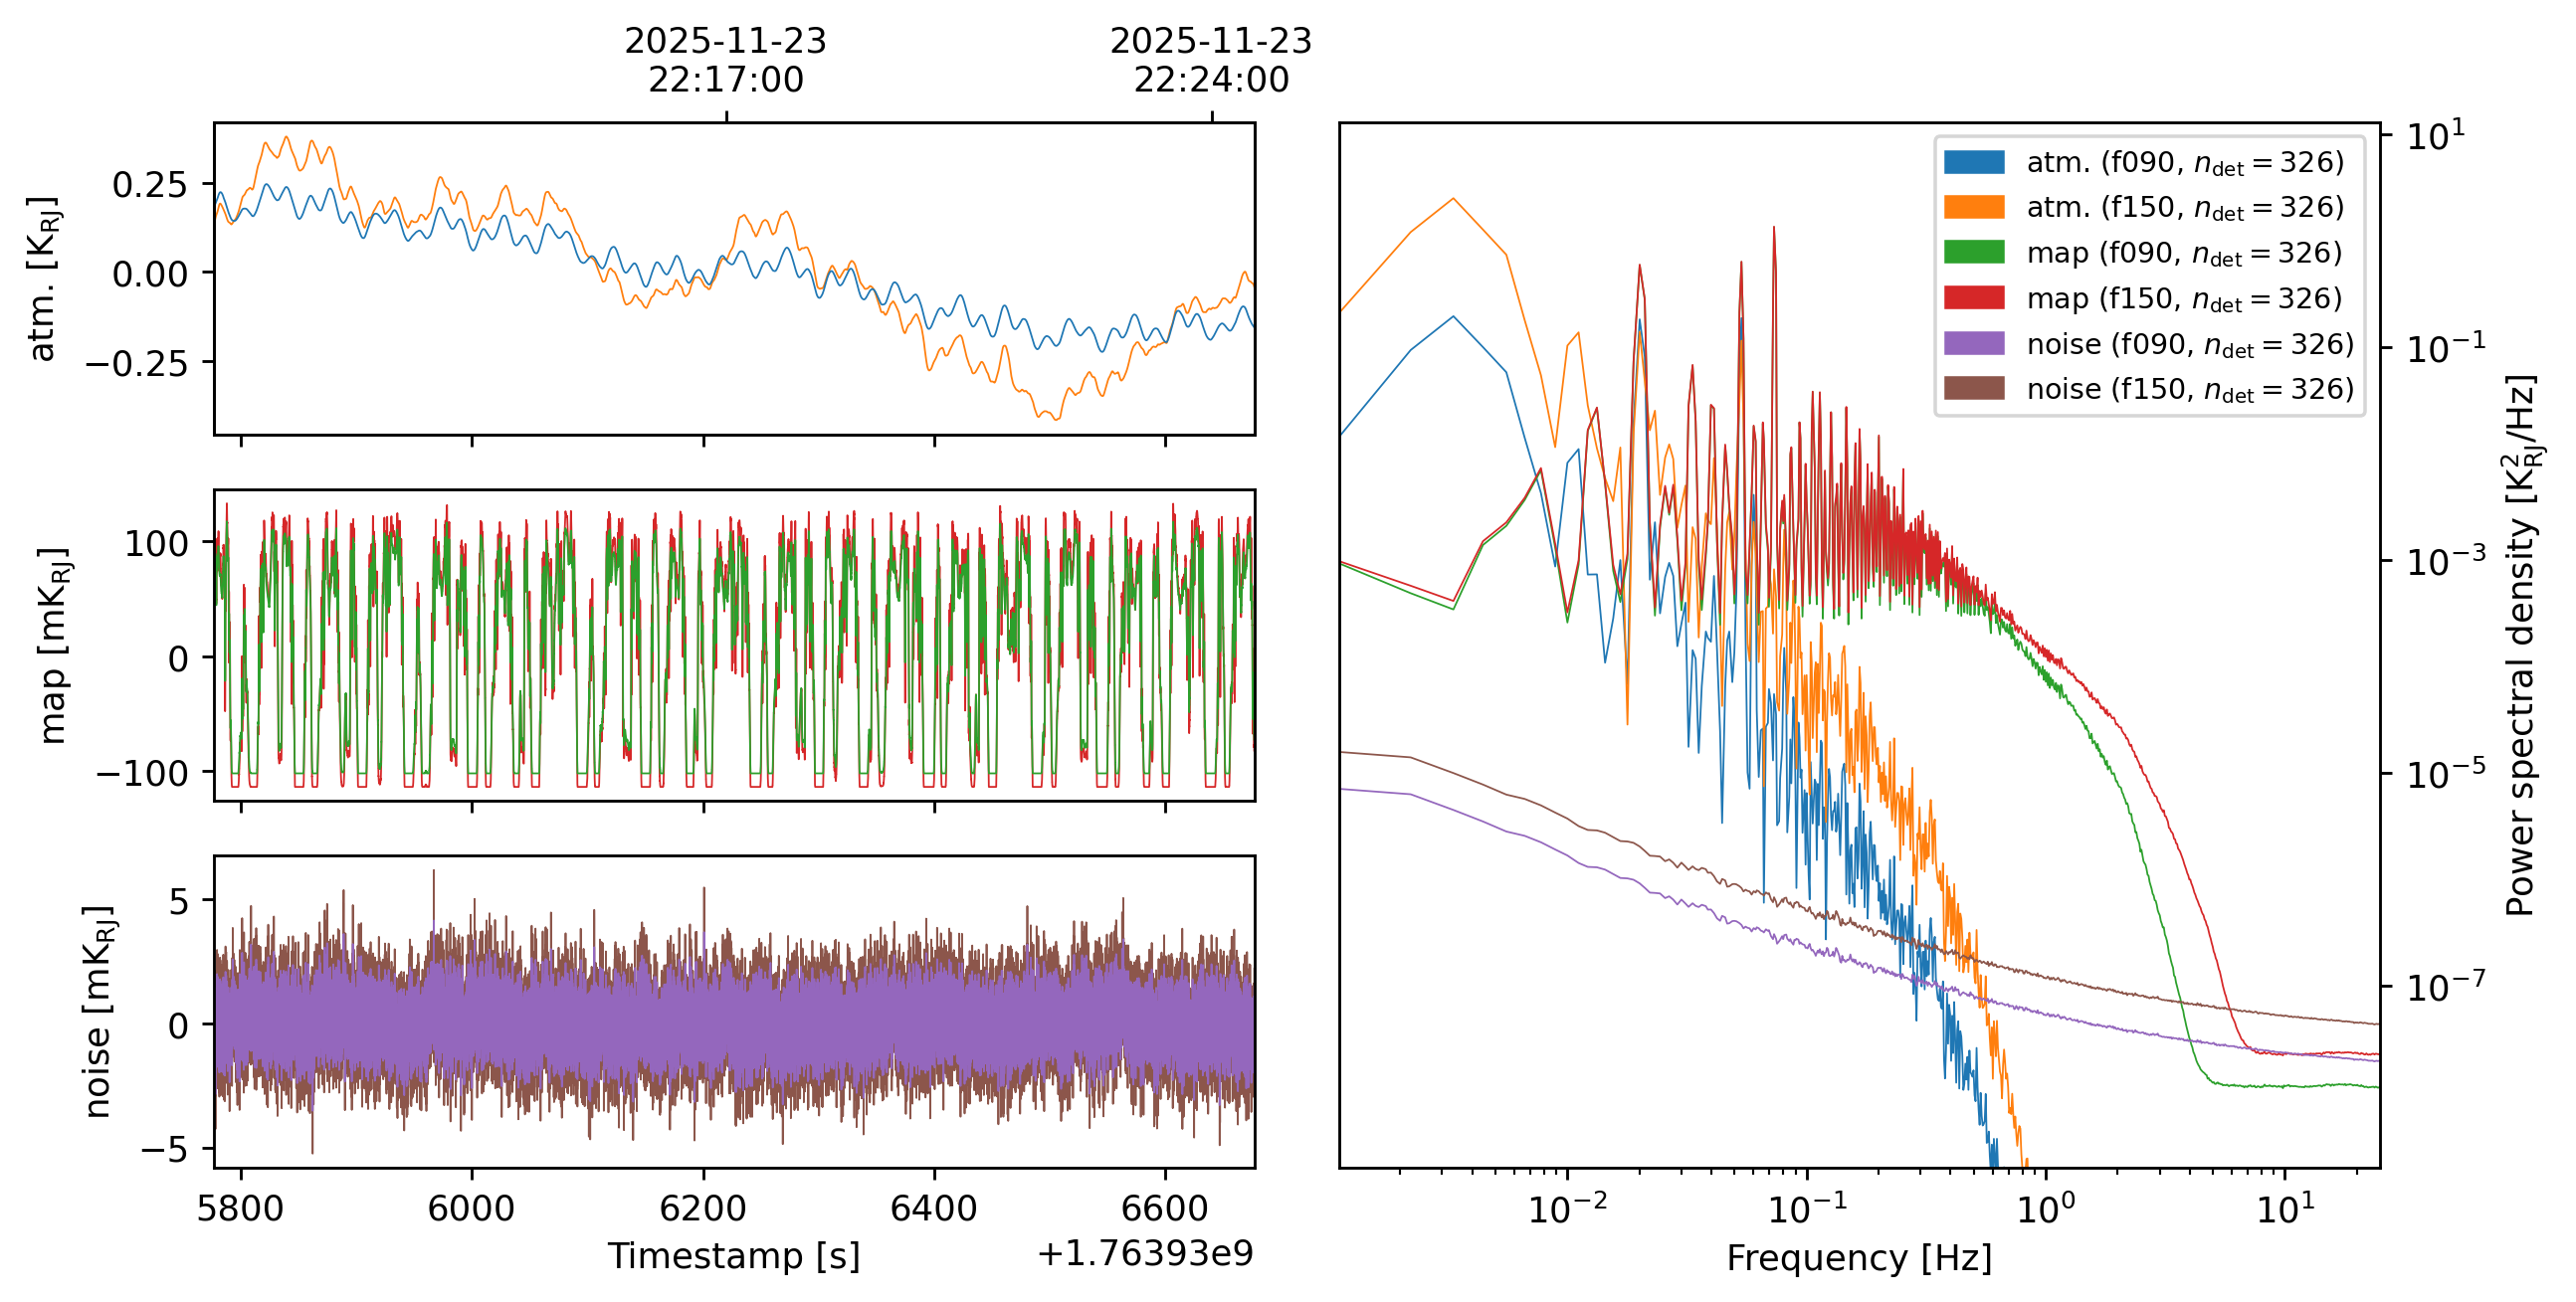

In [6]:
tods = sim.run()

print(tods)
tods[0].plot()

In [7]:
from maria.mappers import BinMapper

mapper = BinMapper(
    stokes="IQUV",
    frame="ra/dec",
    resolution=0.25 / 60,
    tod_preprocessing={
        "remove_spline": {"knot_spacing": 60, "remove_el_gradient": True},
        "remove_modes": {"modes_to_remove": 1},
    },
    map_postprocessing={
        "gaussian_filter": {"sigma": 1},
    },
    units="mK_RJ",
    tods=tods,
)

output_map = mapper.run()

print(output_map)

2025-11-23 19:45:27.783 INFO: Inferring center {'ra': '00ʰ00ᵐ0.77ˢ', 'dec': '-22°59’55.52”'} for mapper.


2025-11-23 19:45:27.797 INFO: Inferring mapper width 1.462° for mapper from observation patch.


2025-11-23 19:45:27.797 INFO: Inferring mapper height 1.462° to match supplied width.


Preprocessing TODs:   0%|                | 0/1 [00:00<?, ?it/s]

Preprocessing TODs: 100%|████████████████| 1/1 [00:02<00:00,  2.18s/it]

Preprocessing TODs: 100%|████████████████| 1/1 [00:02<00:00,  2.18s/it]

Mapping:   0%|          | 0/1 [00:00<?, ?it/s, tod=1/1]

Mapping: 100%|██████████| 1/1 [00:07<00:00,  7.12s/it, tod=1/1]

Mapping: 100%|██████████| 1/1 [00:07<00:00,  7.13s/it, tod=1/1]


2025-11-23 19:45:37.323 WARNING: No counts for map (stokes=V, nu=90 GHz)


2025-11-23 19:45:37.332 WARNING: No counts for map (stokes=V, nu=150 GHz)


ProjectionMap:
  shape(stokes, nu, t, y, x): (4, 2, 1, 350, 350)
  stokes: IQUV
  nu: [ 90. 150.] GHz
  t: [1.76393623e+09]
  z: naive
  quantity: rayleigh_jeans_temperature
  units: K_RJ
    min: -1.158e-01
    max: 1.423e-01
    rms: nan
  center:
    ra: 00ʰ00ᵐ0.77ˢ
    dec: -22°59’55.52”
  size(y, x): (1.458°, 1.458°)
  resolution(y, x): (15”, 15”)
  beam(maj, min, rot): [[[1.45801568 1.45801568 0.        ]]

 [[0.87480941 0.87480941 0.        ]]]’
  memory: 15.68 MB


Note that we can't see any of the circular polarization, since our instrument isn't sensitive to it.

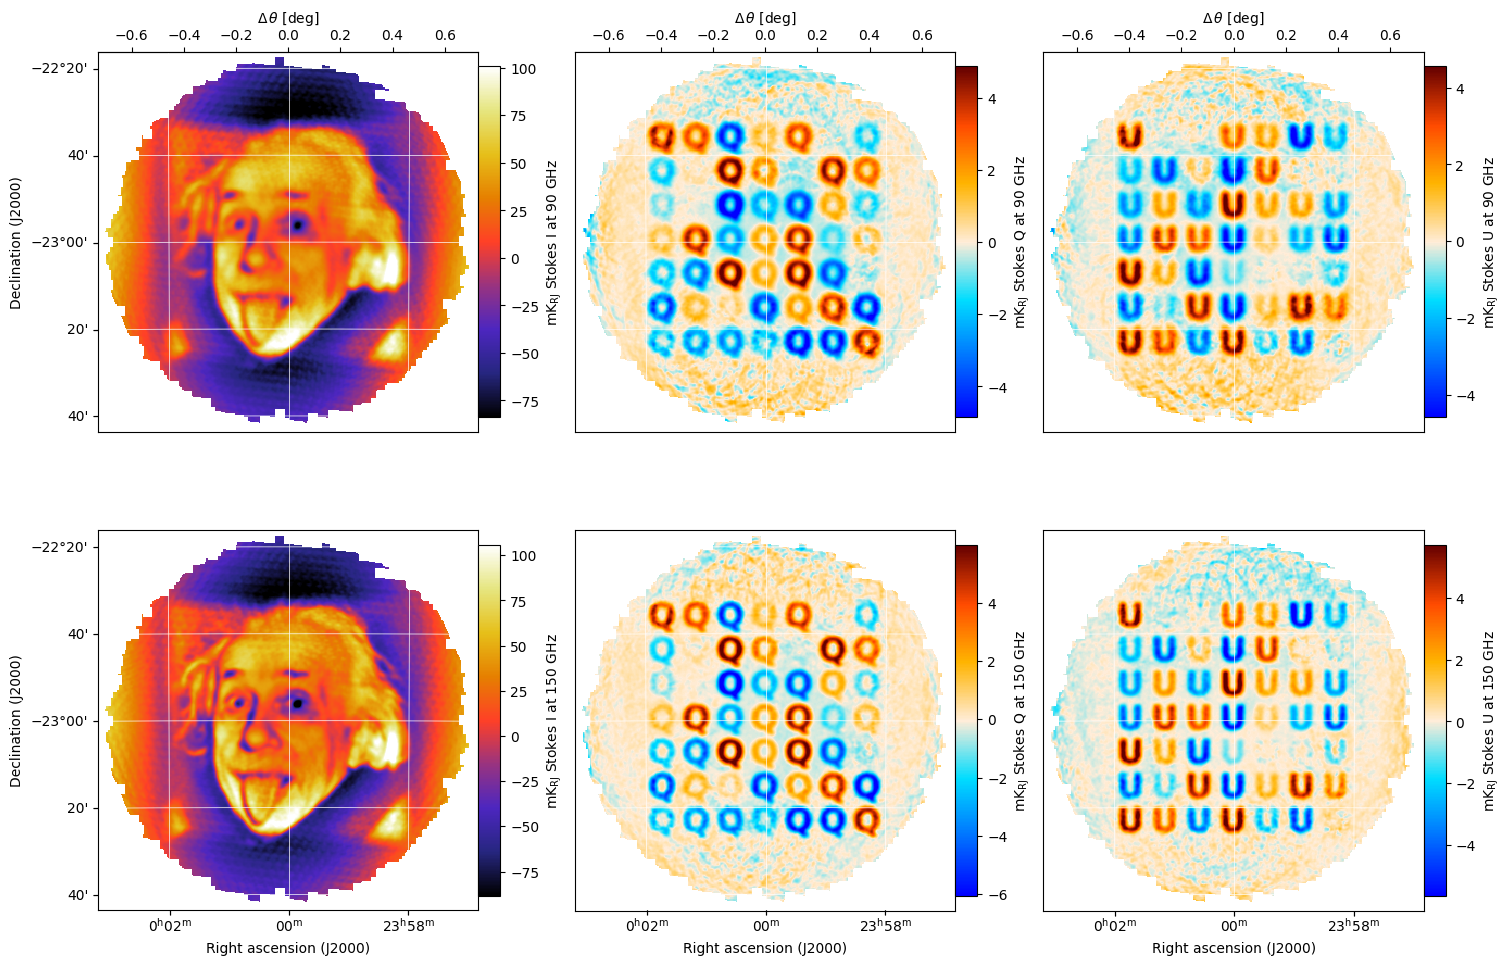

In [8]:
output_map.plot(stokes=["I", "Q", "U"], nu_index=[[0], [1]])